# Anomaly Detection in Azure ML Studio

Example anomaly detection machine learning job using a hybrid of Azure AI Machine Learning console resources combined with native Python in this Jupyter notebook which is intended to be uploaded and executed from 'Authoring -> Notebooks' in the web console. 

## Requirements

1. You should already have created an Azure account, and created a [Subscription](https://techcommunity.microsoft.com/discussions/azure/understanding-azure-account-subscription-and-directory-/34800) and a [Workspace](https://learn.microsoft.com/en-us/azure/machine-learning/concept-workspace?view=azureml-api-2).
2. this exercise assumes that you've already downloaded the [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) dataset from kaggle, and stored this in 'Assets -> Data' inside your Azure account under the name, 'creditcard_fraud'.**

## About Jupyter Notebooks

Jupyter Notebooks originated from the **IPython project**, which was created to provide an interactive computing environment for Python. Over time, it evolved into the broader **Jupyter Project** ("JU" for Julia, "PY" for Python, and "R" for R), supporting multiple programming languages. What makes Jupyter Notebooks so popular in data science is their ability to **combine code, outputs, text, math, and visualizations in one place**. This format is ideal for exploration, analysis, documentation, and teaching. Because of this flexibility and transparency, Jupyter has become a standard across cloud platforms like **Google Colab, Azure AI Machine Learning, and AWS SageMaker** — each offering hosted environments where users can write and execute notebooks with scalable cloud compute. These platforms support the same notebook format (.ipynb), making it easy to move your work between local machines and cloud services.

Thus, you can run this notebook from either of the Azure AI Machine Learning web console, or locally, assuming that you've created and activated the [Python virtual environment](https://realpython.com/python-virtual-environments-a-primer/) provided in the course [GitHub repository](https://github.com/FullStackWithLawrence/azureml-example) for Python 3.9


## Workflow

### Step 1: import the PyPi packages


In [2]:
# Step 1: Import Packages and Connect to your Azure Workspace
from azureml.core import Workspace, Dataset         # see https://pypi.org/project/azureml-core/
import pandas as pd                                 # see https://pandas.pydata.org/docs/
from sklearn.ensemble import IsolationForest        # see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
from sklearn.metrics import classification_report   # see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
import joblib                                       # see https://joblib.readthedocs.io/en/latest/
                                                    #     Joblib is a set of tools to provide lightweight pipelining in Python
from azureml.core.model import Model                # see https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.model?view=azure-ml-py 

### Step 2: Load the Credit Card Fraud Dataset from Azure ML

Retrieve the dataset from our existing workspace, and set this up for use with Pandas.

**IMPORTANT: be mindful of the size of the dataset that you're working with. For example, if you run this notebook locally then be aware that you're downloading around 150Mib from your Azure workspace. When running locally this snippet will take approximately 4 minutes to run.**

#### What This Code Does

- **`Workspace.from_config()`** connects to your Azure ML workspace using the `config.json` file (you should already have this if you followed earlier lectures).
- **`Dataset.get_by_name(...)`** loads the dataset you previously uploaded and registered in the Azure ML web interface.
- **`.to_pandas_dataframe()`** converts the Azure Dataset into a standard pandas DataFrame so you can explore and manipulate it with Python.
- **`df.head()`** shows the first 5 rows of the data — this is just a quick preview to confirm that the dataset loaded correctly.

#### Why This Matters

This is the standard pattern you’ll use throughout Azure ML when working with registered datasets in notebooks. It keeps your workflow consistent and lets you:
- Avoid re-uploading data every time.
- Ensure reproducibility across experiments and pipelines.
- Easily switch to remote compute environments without changing your code.

#### Console output

You might (probably) see a few console output messages. This is expected. They come from Azure’s background systems for logging and monitoring.  
Unless you see an actual `ERROR` or `Traceback`, you can **safely ignore** any of the following.

- **`Warning: Falling back to use azure cli login credentials.`**  
  - Azure is using your Azure CLI login (`az login`) for authentication.
  - ✅ This is normal and expected for local development.
  - ⚠️ For production, consider using `ServicePrincipalAuthentication` or `MsiAuthentication`.

- **`{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}`**  
  - The dataset is being converted to a pandas DataFrame.
  - Azure is not auto-detecting column types.
  - ✅ This means `to_pandas_dataframe()` is working.

- **`Timeout was exceeded in force_flush().`**  
  - A background telemetry system couldn’t send logging data in time.
  - ✅ This is safe to ignore. It has no effect on your code or data.

- **`Overriding of current TracerProvider / LoggerProvider / MeterProvider is not allowed`**  
  - Azure's telemetry was already initialized; it's skipping a duplicate setup.
  - ✅ This is common and harmless in notebook environments.

- **`Attempting to instrument while already instrumented`**  
  - Azure ML SDK tried to attach diagnostics tools (e.g., to pandas or HTTP), but they were already connected.
  - ✅ This is internal setup noise — not an error.


In [3]:
ws = Workspace.from_config()
dataset = Dataset.get_by_name(ws, name='creditcard_fraud')
df = dataset.to_pandas_dataframe()
df.head()

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}


Timeout was exceeded in force_flush().
Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Step 3: Prepare the Data

we're going to normalize the distribution of the transaction $ amount column, which helps the model treat transaction amounts on the same scale as the other features (which are already normalized).

#### What This Code Does

- **Standardizes the `Amount` column**:  
  We scale the `Amount` feature so that it has a mean of 0 and a standard deviation of 1.  
  
- **Creates feature and label sets**:
  - `X` contains the features used to make predictions.
  - `y` contains the target variable: `Class` (where `1 = fraud` and `0 = normal`).

- We also drop the `Time` column since it doesn't contribute meaningfully to anomaly detection in this context.

#### Why This Matters

Many machine learning algorithms — including Isolation Forest — perform better when numeric features are on a similar scale.  
Also, splitting the data into `X` and `y` is a standard step that prepares it for training and evaluation.

In [4]:
df['Amount'] = (df['Amount'] - df['Amount'].mean()) / df['Amount'].std()
X = df.drop(columns=['Class', 'Time'])
y = df['Class']

### Step 4: Train the model

The **Isolation Forest** algorithm is a popular unsupervised method for **detecting anomalies** in high-dimensional datasets. Instead of learning what “normal” looks like, it works by **isolating outliers** — rare points that are easier to separate from the rest of the data. It does this by randomly splitting the dataset using decision trees and measuring how quickly a data point can be isolated. The idea is that **anomalies require fewer splits to isolate**, because they are different from everything else. Isolation Forest is widely used in **fraud detection**, **network security**, and **industrial monitoring** because it is **fast, efficient**, and handles **large datasets** with many features. In our code, we set the `contamination` parameter to roughly match the known fraction of fraud cases in the dataset.

In [5]:
model = IsolationForest(contamination=0.0017, random_state=42)
model.fit(X)
y_pred = model.predict(X)
y_pred = [1 if x == -1 else 0 for x in y_pred]

### Step 5: Evaluating the Anomaly Detection Model

The table below is a summary of metrics that are calculated from the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). It shows how well our model identified normal and fraudulent transactions:

| Metric       | What It Means                                                                 |
|--------------|--------------------------------------------------------------------------------|
| **Precision** | How often the model was *correct* when it said a transaction was fraud        |
| **Recall**    | How many of the *actual fraud cases* the model successfully found             |
| **F1-Score**  | A balance between precision and recall — like a combined performance score     |
| **Support**   | The number of examples in each group (normal or fraud) in the real data        |

#### Results Summary

| Class | Description           | Precision | Recall | F1-Score | Support |
|-------|------------------------|-----------|--------|----------|---------|
| `0`   | Normal transactions    | **1.00**  | **1.00** | **1.00**   | 284,315 |
| `1`   | Fraudulent transactions| **0.29**  | **0.28** | **0.28**   | 492     |

#### Interpretation (In Simple Terms)

- The model is **excellent at recognizing normal transactions** — it almost never makes a mistake with those.
- However, it **struggles to correctly catch fraud**:
  - When it says a transaction is fraud, it’s **only right 29% of the time**.
  - It **only finds 28% of the real fraud cases** — it misses most of them.

#### Overall Accuracy

- The model is **99.9% accurate**, but this is misleading.
- Because **fraud cases are very rare**, the model can look “perfect” just by saying everything is normal.
- That’s why we look at **precision**, **recall**, and **F1-score** for a fuller picture.


In [6]:
# Step 5: Evaluate Model
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.29      0.28      0.28       492

    accuracy                           1.00    284807
   macro avg       0.64      0.64      0.64    284807
weighted avg       1.00      1.00      1.00    284807



### Step 6 (Optional): Register the Model


In [ ]:
joblib.dump(model, 'isolation_forest.pkl')
Model.register(model_path='isolation_forest.pkl',
               model_name='creditcard_if_model',
               workspace=ws)


### Step 7: Visual a Count of Predicted Anomalies

The chart below is a typical summarization of an anomaly detection analysis. It shows how many transactions the model predicted as **normal (0)** and **anomalies/fraud (1)**:

- **X-axis**: The prediction labels.
  - `0` means the model thinks the transaction is **normal**.
  - `1` means the model thinks the transaction is **fraud** or **anomalous**.
- **Y-axis**: The total number of transactions in each category.

#### How to Interpret This Chart

- You will (hopefully) see a **very tall bar for `0`** and a **very short bar for `1`**.
- This is because **fraud is rare** in the dataset (only 492 out of 284,807 transactions).
- The model is trained to detect outliers, so it **flags a small number of transactions as anomalies** (which is expected).
- If the number of predicted frauds is **close to the actual number** (around 500), that’s a good sign that the model is well-calibrated.

#### Why This Matters

- This simple chart gives a **quick health check** of how aggressive or conservative the model is in flagging anomalies.
- If the model predicts **too many anomalies**, it might be overreacting.
- If it predicts **almost none**, it might be too cautious — missing fraud cases.

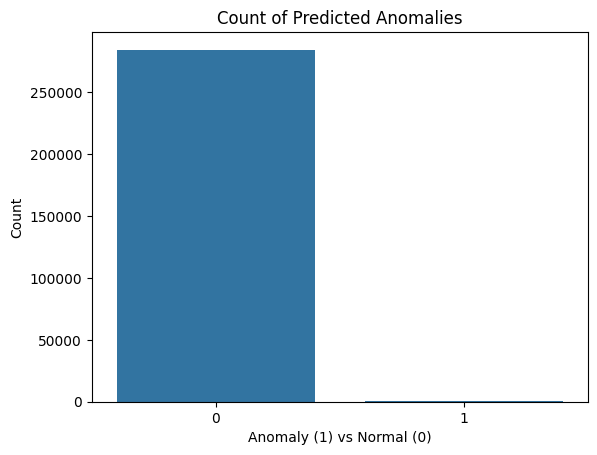

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add predictions to the original dataframe
df['predicted_anomaly'] = y_pred

# Count of predicted anomalies
sns.countplot(x='predicted_anomaly', data=df)
plt.title('Count of Predicted Anomalies')
plt.xlabel('Anomaly (1) vs Normal (0)')
plt.ylabel('Count')
plt.show()


### Step 7 (continued): Visualize Transaction Amount by Prediction Class

The boxplot below compares the **amount of money** in transactions that the model predicted as **normal (0)** or **anomalous/fraud (1)**.

- **X-axis**: The model’s prediction.
  - `0` = predicted normal transaction
  - `1` = predicted fraud/anomaly
- **Y-axis**: The dollar **amount** of each transaction (standardized)

#### How to Interpret This Chart

- Each box shows how transaction amounts are distributed for each prediction class.
- The **line in the middle** of each box is the **median** transaction amount.
- The **height of the box** shows where most transaction amounts fall.
- **Dots outside the box** are **outliers** — unusual values far from the average.

#### What This Tells Us

- You may see that predicted frauds (`1`) tend to have **more extreme** or **variable amounts**.
- This could suggest that the model is flagging **unusually high or low transaction amounts** as suspicious.
- If the fraud predictions have a **much wider range**, it means the model may be reacting to extreme values — which is common in anomaly detection.

#### Usefulness

This chart helps you:
- Understand what kinds of amounts the model thinks are suspicious.
- Spot any bias in the model (e.g. only flagging large transactions).
- Decide whether you need to normalize, transform, or engineer features differently.

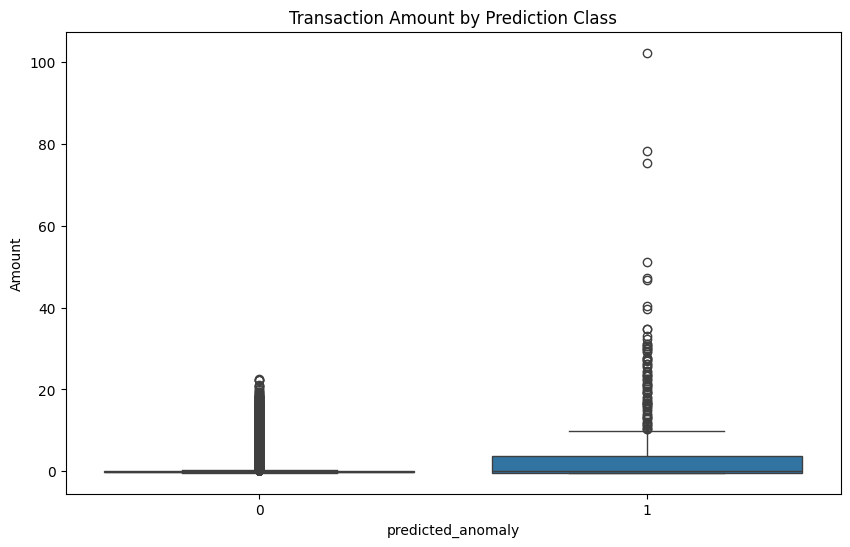

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='predicted_anomaly', y='Amount')
plt.title('Transaction Amount by Prediction Class')
plt.show()


### Step 7 (continued): SHAP Beeswarm Plot – Feature Importance for Anomaly Detection

The beeswarm plot below is generated using **SHAP** (SHapley Additive exPlanations). It helps explain **which features influenced the model's decisions**, and **how strongly**. We only analyze the first 100 transactions here in order to keep the visualization fast and readable.

#### How to Read the SHAP Beeswarm Plot

- **Each dot** represents a single transaction.
- **Each row** is one feature (like `V1`, `V2`, `Amount`, etc.).
- **Color** shows the feature value for that transaction:
  - **Red = high** value
  - **Blue = low** value
- **Horizontal position** shows **impact on the model’s prediction**:
  - Dots farther to the right **push the model toward predicting fraud**.
  - Dots farther to the left **push the model toward predicting normal**.

#### What This Tells Us

- The **topmost features** are the most important ones in the model’s decisions.
- For example, if `V14` is at the top and its red dots are far right, it means:
  - High values of `V14` increase the chance that the model flags a transaction as fraud.
- This plot helps us understand **why** the model flagged certain transactions as anomalies.

#### Why Use SHAP?

- SHAP adds transparency to the model, even for complex algorithms like Isolation Forest.
- Helps **build trust**, especially in sensitive tasks like fraud detection.
- Guides feature selection and **future model improvements**.

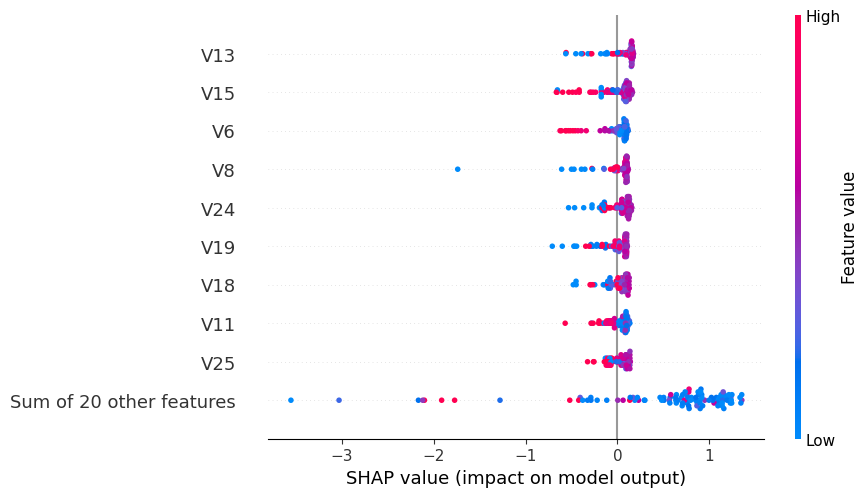

In [9]:
import shap

explainer = shap.Explainer(model, X)
shap_values = explainer(X[:100])
shap.plots.beeswarm(shap_values)